In [58]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# ART
from art.attacks.poisoning import FeatureCollisionAttack
from art.estimators.classification import KerasClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

CIFAR10_LABELS_LIST = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"]

print("使用デバイス:", DEVICE)

#ハイパーパラメータ宣言
BATCH_SIZE = 128
NUM_EPOCHS = 15

train_rate = 0.75
val_rate = 0.20
test_rate =0.05

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                                #transforms.RandomAffine([0,30], scale=(0.8, 1.2)), #大きさと回転
                                transforms.RandomHorizontalFlip(p=0.5),]) #反転

dataset = torchvision.datasets.CIFAR10(root = './', train = True, download = True, transform = transform)
trainset, valtestset = train_test_split(dataset, train_size=train_rate, random_state=0)
valset, testset = train_test_split(valtestset, train_size=val_rate, random_state=0)

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
valloader = DataLoader(valset, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True)

使用デバイス: cuda
Files already downloaded and verified


# データの確認

In [276]:
type(testset[0])

tuple

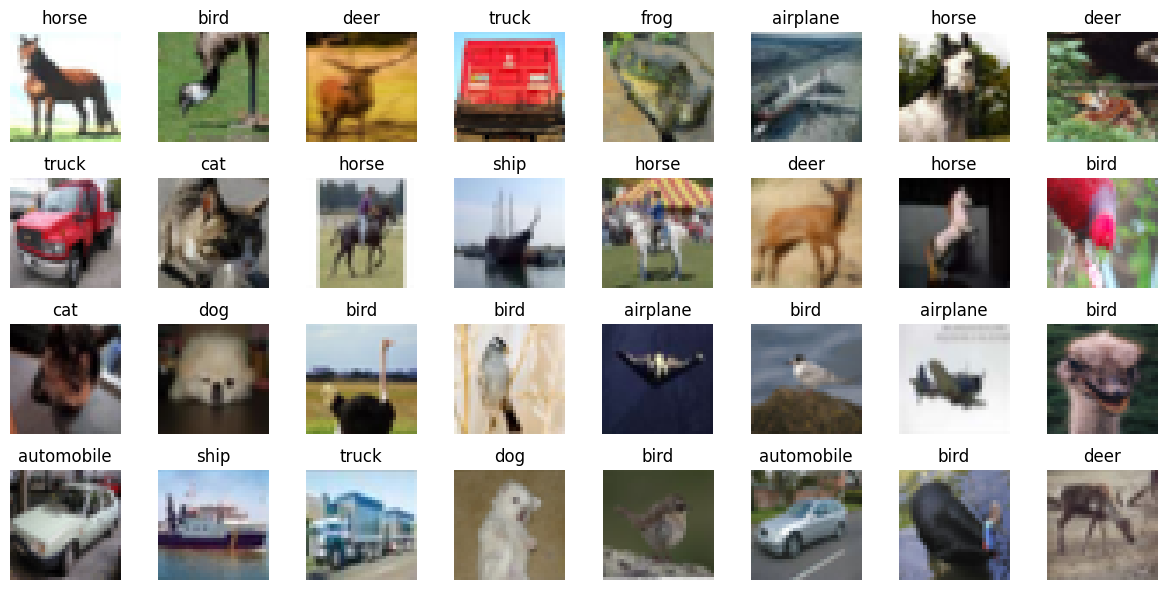

In [16]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    image,label=trainset[i]
    image = torch.permute(image, (1, 2, 0))
    image = image / 2 + 0.5
    ax.imshow(image)
    ax.set_title(CIFAR10_LABELS_LIST[label])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()


In [ ]:
############################################################
#モデルの定義・学習(ローカル)
############################################################

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,128,3,padding='same',padding_mode='replicate') #32-2=30
        self.conv2=nn.Conv2d(128,128,3,padding='same',padding_mode='replicate') #30-2=28
        self.pool1=nn.MaxPool2d(2,2) #28/2=14
        self.conv3=nn.Conv2d(128,64,3,padding='same',padding_mode='replicate') #14-2=12
        self.conv4=nn.Conv2d(64,64,3,padding='same',padding_mode='replicate') #12-2=10
        self.pool2=nn.MaxPool2d(2,2) #10/2=5
        self.conv5=nn.Conv2d(64,32,3,padding='same',padding_mode='replicate') #14-2=12
        self.conv6=nn.Conv2d(32,32,3,padding='same',padding_mode='replicate') #12-2=10
        self.pool3=nn.MaxPool2d(2,2) #10/2=5
        self.fc1=nn.Linear(32 * 4 * 4, 512)
        self.fc2=nn.Linear(512, 256)
        self.fc3=nn.Linear(256, 10)
        self.silu=F.silu
        self.dropout=nn.Dropout(0.25)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.silu(x)
        x = self.conv2(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.silu(x)
        x = self.conv4(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.silu(x)
        x = self.conv6(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.pool3(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.silu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.silu(x)
        x = self.fc3(x)
        return x

In [23]:
#net = Net().to(DEVICE)
net = torchvision.models.resnet50(pretrained=True)
net.fc = nn.Linear(in_features=net.fc.in_features,out_features=10)
net.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
net=net.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
def train(net, trainloader, epoch):
    correct, total, loss, train_loss = 0.0, 0.0, 0.0, 0.0
    net.train()
    for images, labels in trainloader:
        images=images.to(DEVICE)
        labels=labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss 
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
            
    train_loss /= len(trainloader)
    train_acc = correct / total
    print(f"Epoch {epoch+1}: train loss {round(train_loss.item(),4)}, accuracy {round(train_acc,4)}")

    return  train_loss.item(), train_acc


def test(net, testloader, epoch):
    
    net.eval()
    correct, total, loss, val_loss = 0.0, 0.0, 0.0, 0.0
    
    with torch.no_grad():
        for images, labels in testloader:
            images=images.to(DEVICE)
            labels=labels.to(DEVICE)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss 
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
            
    val_loss /= len(testloader)
    val_acc = correct / total
    if epoch > -1:
        print(f"Epoch {epoch+1}: validation loss {round(val_loss.item(),4)}, accuracy {round(val_acc,4)}")
    else:
        print(f"Final test set performance:\n\tloss {round(val_loss.item(),4)}\n\taccuracy {round(val_acc,4)}")
        
    return  val_loss.item(), val_acc

In [24]:
for images, labels in testloader:
    break
print(type(images))

<class 'torch.Tensor'>


In [25]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(NUM_EPOCHS):
    print(f"start epoch:{epoch+1}")
    train_loss, train_acc = train(net, trainloader, epoch)
    val_loss, val_acc = test(net, valloader, epoch)#検証データセットによる評価
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

torch.save(net.state_dict(), 'cnn.pkl')
test(net, testloader, -1) #テストデータセットによる評価

start epoch:1
Epoch 1: train loss 1.1742, accuracy 0.5898
Epoch 1: validation loss 0.8472, accuracy 0.7004
start epoch:2
Epoch 2: train loss 0.7101, accuracy 0.7594
Epoch 2: validation loss 0.8975, accuracy 0.7132
start epoch:3
Epoch 3: train loss 0.5021, accuracy 0.828
Epoch 3: validation loss 0.6041, accuracy 0.7972
start epoch:4
Epoch 4: train loss 0.3454, accuracy 0.8807
Epoch 4: validation loss 0.589, accuracy 0.8068
start epoch:5
Epoch 5: train loss 0.2572, accuracy 0.9139
Epoch 5: validation loss 0.6564, accuracy 0.7924
start epoch:6
Epoch 6: train loss 0.201, accuracy 0.9301
Epoch 6: validation loss 0.651, accuracy 0.804
start epoch:7
Epoch 7: train loss 0.189, accuracy 0.9346
Epoch 7: validation loss 0.5705, accuracy 0.8224
start epoch:8
Epoch 8: train loss 0.1099, accuracy 0.962
Epoch 8: validation loss 0.7564, accuracy 0.786
start epoch:9
Epoch 9: train loss 0.0988, accuracy 0.9658
Epoch 9: validation loss 0.7956, accuracy 0.798
start epoch:10
Epoch 10: train loss 0.2438, ac

(0.837974488735199, 0.8036)

Text(0, 0.5, 'acc')

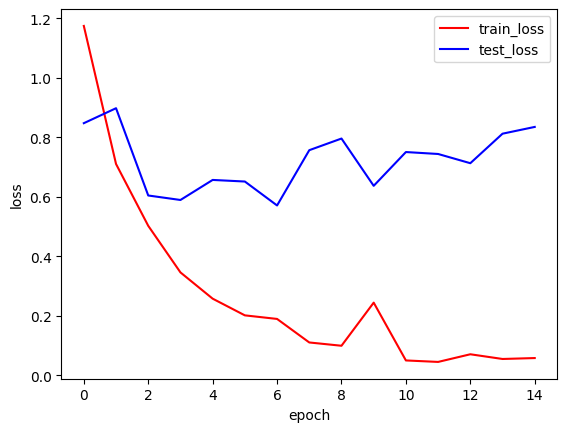

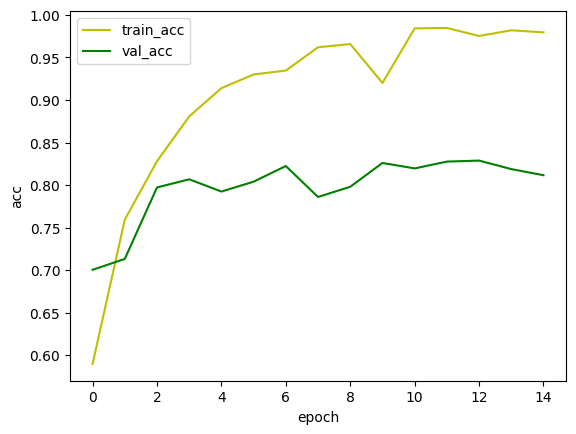

In [27]:
plt.plot(range(NUM_EPOCHS), train_loss_list, 'r-', label='train_loss')
plt.plot(range(NUM_EPOCHS), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(NUM_EPOCHS), train_acc_list, 'y-', label='train_acc')
plt.plot(range(NUM_EPOCHS), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

In [47]:
print(net)

Net(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(

In [95]:
# [1-2]
# 必要なライブラリのインポート
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow with Keras.
#import tensorflow as tf
#from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
#from tensorflow.keras.layers import MaxPooling2D, Dropout
#tf.compat.v1.disable_eager_execution()

# ART
from art.attacks.poisoning import FeatureCollisionAttack
from art.estimators.classification import PyTorchClassifier

In [337]:
from art.utils import load_cifar10
# 特徴量は0.0～1.0の範囲に収まるように正規化しているため、最小値は0.0、最大値は1.0とする。
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
num_samples_train = 2000
num_samples_test = 2000
x_train = x_train[0:num_samples_train]
y_train = y_train[0:num_samples_train]
x_test = x_test[0:num_samples_test]
y_test = y_test[0:num_samples_test]

x_train[0].shape

(32, 32, 3)

In [338]:
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=net,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

In [202]:
x_test.shape

(10000, 32, 32, 3)

In [339]:
target_class = "bird" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
target_label = np.zeros(len(CIFAR10_LABELS_LIST))
target_label[CIFAR10_LABELS_LIST.index(target_class)] = 1
target_instance = x_test[np.argmax(y_test, axis=1) == CIFAR10_LABELS_LIST.index(target_class)][5]
target_instance = np.expand_dims(target_instance, axis=0)
target=np.transpose(target_instance, (0, 3, 1, 2)).astype(np.float32)

targetimg = torch.from_numpy(target.astype(np.float32))
targetimg =targetimg.to(DEVICE)
output = net(targetimg)
_, target_predicted = torch.max(output, 1)

In [332]:
x_train.shape

(1000, 32, 32, 3)

In [340]:
import torch.optim as optim
x_train=np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
net.train()
classifier.fit(x_train, y_train, nb_epochs=20, batch_size=4)

In [343]:
targetimg = torch.from_numpy(target.astype(np.float32))
targetimg =targetimg.to(DEVICE)
output = net(targetimg)
_, target_predicted = torch.max(output, 1)

shape of target_instance (1, 32, 32, 3)
true_class: bird
predicted_class: bird
avgpool
tensor([[-11.5827, -39.5726,  17.7340,  17.1070,  17.2716,  16.1312,  16.5168,
          -2.4232,  11.3710, -40.7650]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


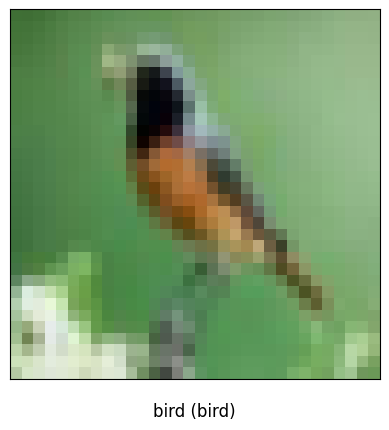

In [344]:
img_plot = np.squeeze(target_instance)
fig = plt.imshow(img_plot)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.text(0.5, -0.1, CIFAR10_LABELS_LIST[target_predicted] + " (" + target_class + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

print("shape of target_instance",target_instance.shape)
print('true_class: ' + target_class)
print('predicted_class: ' + CIFAR10_LABELS_LIST[target_predicted])

feature_layer = classifier.layer_names[-2]
print(feature_layer)
print(output)

In [256]:
base_class = "cat" # one of ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
base_idxs = np.argmax(y_test, axis=1) == CIFAR10_LABELS_LIST.index(base_class)
base_instances = np.copy(x_test[base_idxs][:10])
base_labels = y_test[base_idxs][:10]
x_test_pred=[]
base_list=[]
for i in range(10):
    baseimg = np.expand_dims(x_test[base_idxs][i], axis=0)
    baseimg = np.transpose(baseimg, (0, 3, 1, 2)).astype(np.float32)
    base_list.append(baseimg)
    baseimg = torch.from_numpy(baseimg.astype(np.float32))
    baseimg = baseimg.to(DEVICE)
    outputs = net(baseimg)
    _, predicted = torch.max(outputs, 1)
    x_test_pred.append(predicted.cpu().item())
    
#x_test_pred = np.argmax(classifier.predict(base_instances), axis=1)

nb_correct_pred = np.sum(x_test_pred == np.argmax(base_labels, axis=1))

print("New test data to be poisoned (10 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(10-nb_correct_pred))

New test data to be poisoned (10 images):
Correctly classified: 9
Incorrectly classified: 1


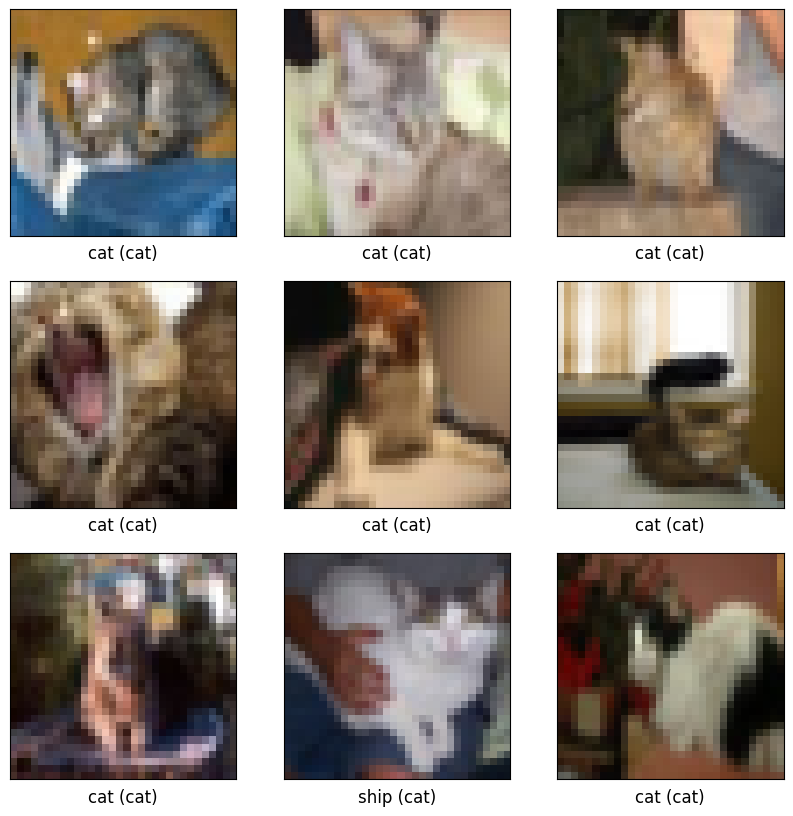

In [257]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = CIFAR10_LABELS_LIST[x_test_pred[i]], CIFAR10_LABELS_LIST[np.argmax(base_labels[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(base_instances[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

In [258]:
attack = FeatureCollisionAttack(classifier=classifier,
                                target=target,
                                feature_layer= classifier.layer_names[-2],
                                learning_rate=1,
                                max_iter=10,
                                watermark=0.3,
                                similarity_coeff=256.0)

print( classifier.layer_names[-2])

avgpool


In [259]:
poison=[]
poison_labels=[]
for i in range(10):
    p, l = attack.poison(x=base_list[i])
    poison.append(p)
    poison_labels.append(l)

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

Feature collision:   0%|          | 0/10 [00:00<?, ?it/s]

In [260]:
poison_pred=[]
poison_list=[]
for i in range(10):
    poisonimg = torch.from_numpy(poison[i].astype(np.float32))
    poisonimg = poisonimg.to(DEVICE)
    outputs = net(poisonimg)
    _, predicted = torch.max(outputs, 1)
    poison_pred.append(predicted.cpu().item())

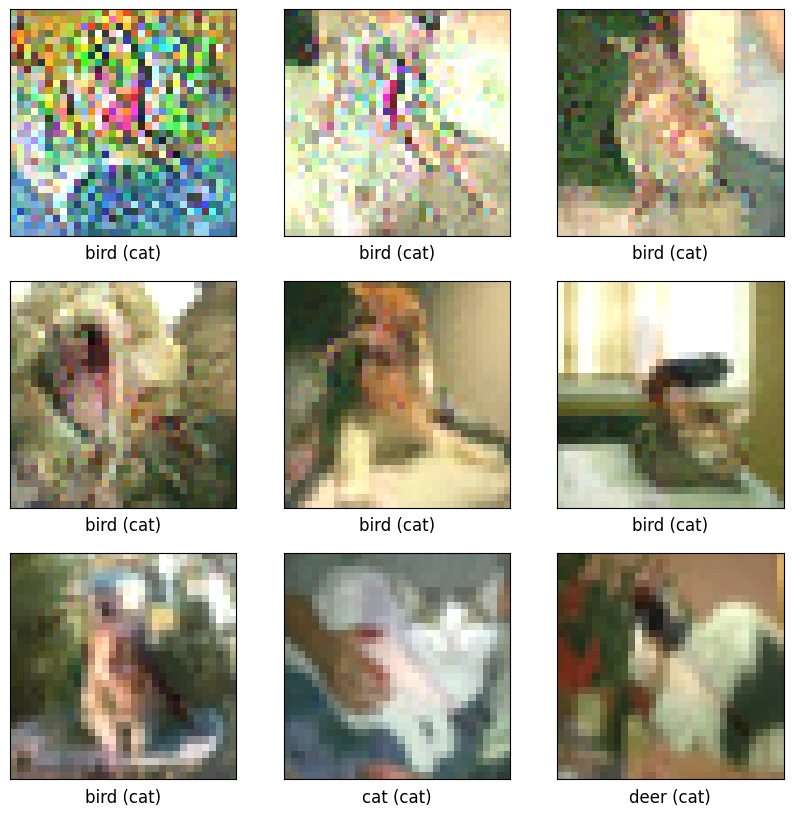

In [261]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label= CIFAR10_LABELS_LIST[poison_pred[i]]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.squeeze(np.transpose(poison[i],(2,3,0,1))))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

In [303]:
p_data=np.array(np.transpose(np.squeeze(poison),(0,2,3,1)))

In [311]:
poison_labels=np.squeeze(poison_labels)
poison_label = np.zeros(len(CIFAR10_LABELS_LIST))
poison_label[np.argmax(poison_labels,axis=1)] = 1

In [345]:
import torch.optim as optim
adv_train = np.vstack([x_train,p_data])
adv_train = np.transpose(adv_train,(0,3,1,2)).astype(np.float32)
adv_labels = np.vstack([y_train, poison_labels]).astype(np.float32)
net.train()
classifier.fit(adv_train, adv_labels, nb_epochs=20, batch_size=4)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 32

In [325]:
targetimg = torch.from_numpy(target.astype(np.float32))
targetimg =targetimg.to(DEVICE)
output = net(targetimg)
_, target_predicted = torch.max(output, 1)

true_class: bird
predicted_class: cat
tensor([[-0.6440, -1.5374,  0.5163,  0.5387,  0.4853,  0.5010,  0.5089, -0.4466,
          0.1476, -1.4906]], device='cuda:0', grad_fn=<DivBackward0>)


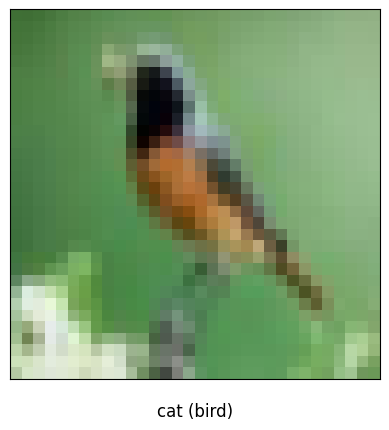

In [326]:
img_plot = np.squeeze(target_instance)
fig = plt.imshow(img_plot)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
fig.axes.text(0.5, -0.1, CIFAR10_LABELS_LIST[target_predicted] + " (" + target_class + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

print('true_class: ' + target_class)
print('predicted_class: ' + CIFAR10_LABELS_LIST[target_predicted])
print(output)

In [329]:
adv_train.shape

(1010, 3, 32, 32)